In [369]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import sympy
import numba
import pandas as pd
from ipywidgets import interact
import seaborn as sns
sns.set(style='ticks', context='paper', font_scale=2)
red, blue, green, purple, orange, yellow = sns.color_palette('Set1', 6)
from IPython.display import display_latex

import sys
sys.path.append('../src/')
from simulation import *
from plots import *

In [370]:
from sympy import *
init_printing()

In [371]:
from rakott.mpl import fig_xlabel, fig_ylabel, fig_panel_labels, savefig_bbox, legend_out

# Recurrence illustration

In [372]:
# @numba.jit()
def recurrence(x, ρ, wA, wB, N=0):
    N = int(N)
    w = x * wA + (1 - x) * wB
    x = x * (1 - ρ + ρ * wA/w)
    if N > 0:
        x = np.random.binomial(N, x) / N
    return x

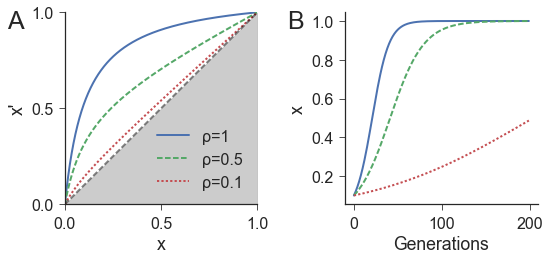

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
x = np.linspace(0, 1, 10000)
ρs = [1, 0.5, 0.1]
W = 1
w = 0.9

for ρ, ls in zip(ρs, ('solid', 'dashed', 'dotted')):
    xx = recurrence(x, ρ=ρ, wA=1.0, wB=0.1)
    ax.plot(x, xx, lw=2, ls=ls, label='ρ={}'.format(ρ))
ax.plot(x, x, ls='--', alpha=0.5, lw=2, color='k')
ax.fill_between(x, x, color='k', alpha=0.2)

ax.set(
    xlabel='x',
    ylabel='x\'',
    xlim=(0, 1),
    ylim=(0, 1),
    xticks=np.linspace(0, 1, 3),
    yticks=np.linspace(0, 1, 3),
)
ax.legend()

ax = axes[1]
n = 200
for ρ, ls in zip(ρs, ('solid', 'dashed', 'dotted')):
    x = np.empty(n)
    x[0] = 0.1
    for t in range(1, n):        
        x[t] = recurrence(x[t - 1], ρ, W, w)
    ax.plot(x, lw=2, ls=ls, label='ρ={}'.format(ρ))

# ax.legend()
ax.set_xlabel('Generations')
ax.set_ylabel('x')
fig_panel_labels(axes, xcoord=-0.3)
fig.tight_layout()
sns.despine()

fig.savefig('../figures/recurrence_example.pdf', dpi=300)
fig.savefig('../figures/recurrence_example.png', dpi=300)

In [627]:
from PIL import Image

im = Image.open('../figures/recurrence_example.png')
w, h = im.size
im.crop((0, 0, w/2, h)).save('../figures/recurrence_example_A.png')
im.crop((w/2, 0, w, h)).save('../figures/recurrence_example_B.png')

# Environment A1B1

In [373]:
@numba.jit()
def x_star(W, w, ρ):
    return 0.5 - (W + w - np.sqrt( (1 - ρ)**2 * (W - w)**2 + 4 * W * w ))/(2 * (2 - ρ) * (W - w))

In [374]:
W = 1
ws = np.logspace(-3, -0.01, 101)
ρs = np.linspace(0, 1, 101)

x = np.array([
    [
        x_star(W, w, ρ)
        for ρ in ρs
    ]
    for w in ws
])
xA1B1 = x

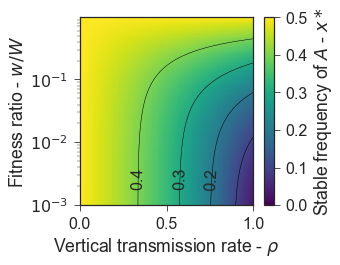

In [309]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

im = ax.pcolormesh(ρs, ws, x, cmap='viridis', vmin=0, vmax=0.5)
cntr = ax.contour(ρs, ws, x, levels=np.arange(0, 1.1, 0.1), linewidths=0.5, colors='k', )
ax.clabel(cntr, fontsize='smaller', fmt='%1.1f', inline=False, colors='#252525',use_clabeltext=True)
plt.colorbar(im, ax=ax, label='Stable frequency of $A$ - $x*$')
ax.set(
    yscale='log',
    xlabel=r'Vertical transmission rate - $\rho$',
    ylabel=('Fitness ratio - $w/W$')
)
fig.tight_layout()

fig.savefig('../figures/A1B1_stable_x.pdf', bbox_inches='tight')#, bbox_extra_artists=txt)
fig.savefig('../figures/A1B1_stable_x.png', bbox_inches='tight')#, bbox_extra_artists=txt)

In [310]:
wbar = np.array([
    [
        x_star(W, w, ρ) * (W - w) + w
        for ρ in ρs
    ]
    for w in ws
])
wbarA1B1 = wbar

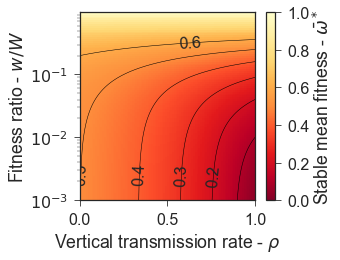

In [311]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

im = ax.pcolormesh(ρs, ws, wbar, cmap='YlOrRd_r', vmin=0, vmax=1)
cntr = ax.contour(ρs, ws, wbar, levels=np.arange(0, 0.7, 0.1), linewidths=0.5, colors='k', )
ax.clabel(cntr, fontsize='smaller', fmt='%1.1f', inline=False, colors='#252525', use_clabeltext=True)
plt.colorbar(im, ax=ax, label=r'Stable mean fitness - $\bar{\omega}^*$')
ax.set(
    yscale='log',
    xlabel=r'Vertical transmission rate - $\rho$',
    ylabel=('Fitness ratio - $w/W$')
)

fig.tight_layout()

fig.savefig('../figures/A1B1_mean_fitness.pdf', bbox_inches='tight')#, bbox_extra_artists=txt)
fig.savefig('../figures/A1B1_mean_fitness.png', bbox_inches='tight')#, bbox_extra_artists=txt)

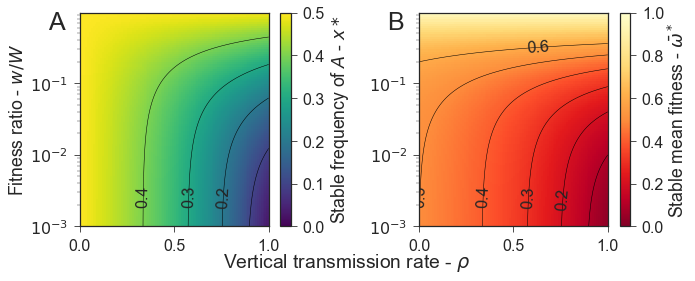

In [375]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
im = ax.pcolormesh(ρs, ws, x, cmap='viridis', vmin=0, vmax=0.5, rasterized=True)
cntr = ax.contour(ρs, ws, x, levels=np.arange(0, 1.1, 0.1), linewidths=0.5, colors='k')
ax.clabel(cntr, fontsize='smaller', fmt='%1.1f', inline=False, colors='#252525',use_clabeltext=True)
plt.colorbar(im, ax=ax, label='Stable frequency of $A$ - $x*$')
ax.set(
    yscale='log',
#     xlabel=r'Vertical transmission rate - $\rho$',
    ylabel=('Fitness ratio - $w/W$')
)

ax = axes[1]
im = ax.pcolormesh(ρs, ws, wbar, cmap='YlOrRd_r', vmin=0, vmax=1, rasterized=True)
cntr = ax.contour(ρs, ws, wbar, levels=np.arange(0, 0.7, 0.1), linewidths=0.5, colors='k', )
ax.clabel(cntr, fontsize='smaller', fmt='%1.1f', inline=False, colors='#252525', use_clabeltext=True)
plt.colorbar(im, ax=ax, label=r'Stable mean fitness - $\bar{\omega}^*$')
ax.set(
    yscale='log',
#     xlabel=r'Vertical transmission rate - $\rho$',
#     ylabel=('Fitness ratio - $w/W$')
)

fig_panel_labels(axes)
fig_xlabel(fig, r'Vertical transmission rate - $\rho$')
fig.tight_layout()

fig.savefig('../figures/A1B1_equilibrium.pdf', bbox_inches='tight')#, bbox_extra_artists=txt)
fig.savefig('../figures/A1B1_equilibrium.png', bbox_inches='tight')#, bbox_extra_artists=txt)

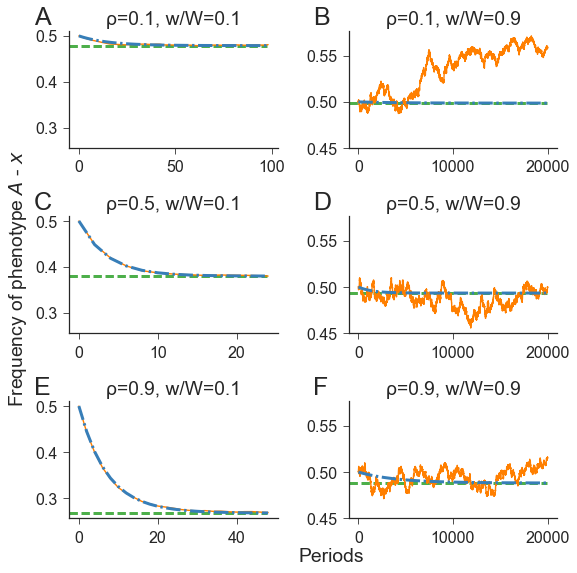

In [45]:
N = 10000
ns = np.array([[100, 20000], [25, 20000], [50, 20000]])
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.9]
W_ = 1.0
fig, axes = plt.subplots(len(ρs), len(ws), figsize=(8, 8), sharex=False, sharey='col')

for i, ρ_ in enumerate(ρs):
    for j, w_ in enumerate(ws):
        ax = axes[i, j]
        n = ns[i, j]
        t_ = range(0, n, 2)
        # analytic solution
        sol = x_star(W_, w_, ρ_)
        ax.axhline(y=sol, xmin=0, xmax=0.95, color=green, lw=3, ls='--', label='Equilibrium')        
        # WF
        reps = 100
        y_ = np.empty(n, float)
        y_[0] = 0.5
        x_ = np.empty((n, reps))
        x_[0, :] = 0.5
        for t in range(1, n):
            wA, wB = (w_, W_) if t % 2 == 0 else (W_, w_)
            y_[t] = recurrence(y_[t - 1], ρ_, wA, wB)
            x_[t, :] = recurrence(x_[t - 1, :], ρ_, wA, wB, N)
        ax.plot(t_, x_.mean(axis=1)[t_], color=orange, label='Finite population')
        ax.plot(t_, y_[t_], color=blue, lw=3, ls='-.', label='Infinite population')
        # styling
        ax.set_title(r'ρ={}, w/W={}'.format(ρ_, w_/W_))
        ax.legend().set_visible(False)

for i in range(2): axes[0, i].set_xlabel('')
for i in range(2): axes[1, i].set_xlabel('')
for i in range(2): axes[i, 1].set_ylabel('')
for i in range(2): axes[i, 0].set_ylabel('')

xlabel = fig_xlabel(fig, 'Periods', xcoord=0.55)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ - $x$', xcoord=0.025)
fig_panel_labels(axes, ycoord=1.05)
fig.tight_layout()
sns.despine()
fig.savefig('../figures/env_A1B1.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight');

# Environment A1B2

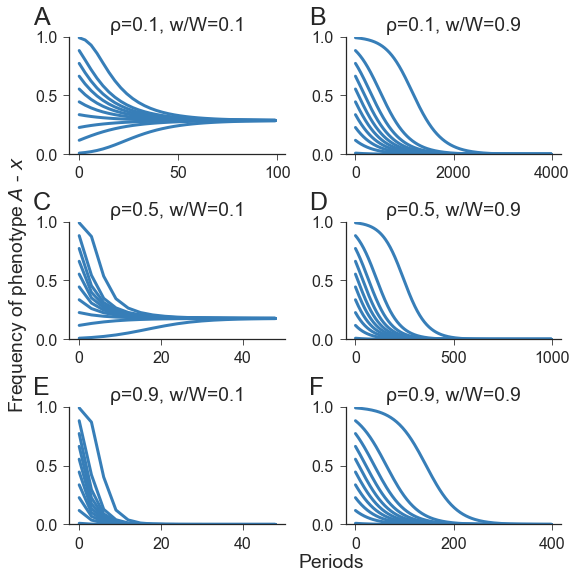

In [46]:
N = 10000
ns = np.array([[100, 4000], [50, 1000], [50, 400]])
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.9]
W_ = 1.0
fig, axes = plt.subplots(len(ρs), len(ws), figsize=(8, 8), sharex=False, sharey="col")

for i, ρ_ in enumerate(ρs):
    for j, w_ in enumerate(ws):
        ax = axes[i, j]
        n = ns[i, j]
        t_ = range(0, n, 3)
        # WF
#         reps = 100
#         x_ = np.empty((n, reps), float)
#         x_[0, :] = 0.5
        y_ = np.empty((n, 10), float)
        y_[0, :] = np.linspace(0.01, 0.99, 10)
        for t in range(1, n):
            wA, wB = (W_, w_) if t % 3 == 2 else (w_, W_)
            y_[t] = recurrence(y_[t - 1], ρ_, wA, wB)
#             x_[t, :] = recurrence(x_[t - 1, :], ρ_, wA, wB, N)
#         ax.plot(t_, x_.mean(axis=1)[t_], color=orange, label='Finite population')
        ax.plot(t_, y_[t_], color=blue, lw=3, ls='-', label='Infinite population')
        # styling
        ax.set_title(r'ρ={}, w/W={}'.format(ρ_, w_/W_))
        ax.set_ylim(0, 1)
        ax.legend().set_visible(False)
#         if (x_[-1,:] == 0).all():
#             ax.text(t, 0.9, 'fixation', fontdict=dict(fontsize=14, horizontalalignment='right'))
#         else:
#             ax.text(t, 0.9, 'polymorphism', fontdict=dict(fontsize=14, horizontalalignment='right'))

for i in range(2): axes[0, i].set_xlabel('')
for i in range(2): axes[1, i].set_xlabel('')
for i in range(2): axes[i, 1].set_ylabel('')
for i in range(2): axes[i, 0].set_ylabel('')

xlabel = fig_xlabel(fig, 'Periods', xcoord=0.55)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ - $x$', xcoord=0.025)
labels = fig_panel_labels(axes, ycoord=1.1)
fig.tight_layout()
sns.despine()
fig.savefig('../figures/env_A1B2.pdf', bbox_extra_artists=[xlabel, ylabel] + labels, bbox_inches='tight');

# Environment A3B10 - sensitivity to initial conditions

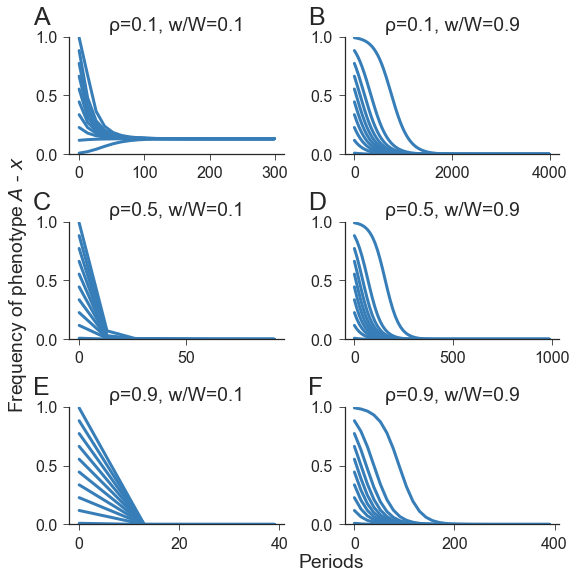

In [365]:
N = 10000
ns = np.array([[300, 4000], [100, 1000], [50, 400]])
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.9]
W_ = 1.0
fig, axes = plt.subplots(len(ρs), len(ws), figsize=(8, 8), sharex=False, sharey="col")

for i, ρ_ in enumerate(ρs):
    for j, w_ in enumerate(ws):
        ax = axes[i, j]
        n = ns[i, j]
        t_ = range(0, n, 13)
        y_ = np.empty((n, 10), float)
        y_[0, :] = np.linspace(0.01, 0.99, 10)
        for t in range(1, n):
            wA, wB = (W_, w_) if t % 13 < 3 else (w_, W_)
            y_[t] = recurrence(y_[t - 1], ρ_, wA, wB)
        ax.plot(t_, y_[t_], color=blue, lw=3, ls='-')
        # styling
        ax.set_title(r'ρ={}, w/W={}'.format(ρ_, w_/W_))
        ax.set_ylim(0, 1)

for i in range(2): axes[0, i].set_xlabel('')
for i in range(2): axes[1, i].set_xlabel('')
for i in range(2): axes[i, 1].set_ylabel('')
for i in range(2): axes[i, 0].set_ylabel('')

xlabel = fig_xlabel(fig, 'Periods', xcoord=0.55)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ - $x$', xcoord=0.025)
labels = fig_panel_labels(axes, ycoord=1.1)
fig.tight_layout()
sns.despine()
fig.savefig('../figures/env_A3B10.pdf', bbox_extra_artists=[xlabel, ylabel] + labels, bbox_inches='tight');

# Environment ABBABB

In [172]:
a,b,c,d,e,f,g,h = symbols('a,b,c,d,e,f,g,h'.replace(',', ' '))
x, ρ, W, w = symbols('x ρ W w')

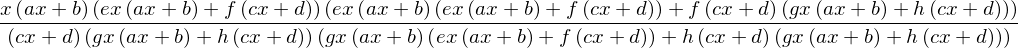

In [173]:
x1 = x*(a*x+b)/(c*x+d)
x2 = x1*(e*x1+f)/(g*x1+h)
x3 = x2*(e*x2+f)/(g*x2+h)
x3 = simplify(x3)
x3

In [174]:
x3num, x3denom = x3.as_numer_denom()
pol = (x3denom*x - x3num).subs(dict(
    e = -a,
    f = ρ*w + (1-ρ)*W,
    g = -c,
    h = W
)).subs(dict(
    a = (1-ρ)*(W-w),
    b = ρ*W + (1-ρ)*w,
    c = W-w,
    d = w,
)).as_poly(x)

In [175]:
pol.degree(), len(pol.all_coeffs())

In [176]:
pol(0), pol(1)

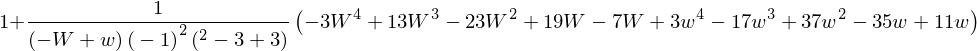

In [177]:
sympy.polys.rootoftools.RootSum(pol)

In [178]:
pol_roots = np.array(sympy.polys.rootoftools.roots(pol.subs({W:1, w:0.41, ρ:0.77}).as_poly(x), multiple=True), dtype=float)
pol_roots

array([ -2.36450967,  -1.65830915,  -0.76230214,  -0.5133686 ,
         0.        ,   1.        ,   2.60957628,  38.18343941])

In [179]:
@interact(w_=(0,1, 0.01), ρ_=(0,1, 0.01))
def _(w_, ρ_):
    pol_roots = np.array(sympy.polys.rootoftools.roots(
        pol.subs({W:1, w:w_, ρ:ρ_}).as_poly(x), multiple=True, filter='R'
    ))
    pol_roots = pol_roots[np.isreal(pol_roots)].astype(float)
    idx = (pol_roots > 0) & (pol_roots < 1) & (~np.isclose(pol_roots, 1)) & (~np.isclose(pol_roots, 0))
    print(pol_roots[idx])

In [180]:
@interact(w_=(0,1, 0.01), ρ_=(0,1, 0.01))
def _(w_, ρ_):
    plot(pol.subs({W:1, w:w_, ρ:ρ_}), (x, 0, 1))

In [183]:
roots_table = []
for w_ in np.linspace(0, 0.5, 50):
    for ρ_ in np.linspace(0, 1, 50):
        pol_roots = np.array(sympy.polys.rootoftools.roots(
            pol.subs({W:1, w:w_, ρ:ρ_}).as_poly(x), multiple=True, filter='R'
        ))
        pol_roots = pol_roots[np.isreal(pol_roots)].astype(float)
        idx = (pol_roots > 0) & (pol_roots < 1) & (~np.isclose(pol_roots, 1)) & (~np.isclose(pol_roots, 0))
        pol_roots = pol_roots[idx]
        if len(pol_roots) > 1:
            print("More than 1! w={}, ρ={}".format(w_, ρ_))
        if len(pol_roots) == 1:
            roots_table.append({'w':w_, 'ρ':ρ_, 'root':pol_roots[0]})
        else:
            roots_table.append({'w':w_, 'ρ':ρ_, 'root': np.nan})

In [184]:
roots_df = pd.DataFrame(roots_table)
roots_df.head()

,root,w,ρ
0,NaN,0.0,0.000000
1,0.326484,0.0,0.020408
2,0.319543,0.0,0.040816
3,0.312509,0.0,0.061224
4,0.305384,0.0,0.081633


In [376]:
x_pivoted = roots_df.pivot('w', 'ρ', 'root')
np.isfinite(x_pivoted.values).all()

False

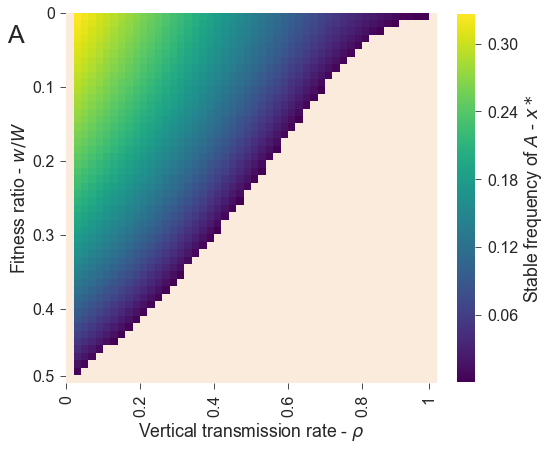

In [377]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(x_pivoted, square=True, ax=ax, cmap='viridis', rasterized=True,
            cbar_kws=dict(fraction=0.045, label='Stable frequency of $A$ - $x*$'))
sns.heatmap(~np.isfinite(x_pivoted), mask=np.isfinite(x_pivoted), square=True, ax=ax, cbar=False)
# cntr = ax.contourf(pivoted)
# ax.clabel(cntr, colors='w')
ax.set_xticks([0, 10, 20, 30, 40, 49])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 10, 20, 30, 40, 49])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel(r'Vertical transmission rate - $\rho$')
ax.set_ylabel(r'Fitness ratio - $w/W$')
# ax.set_title(r'Polymorphism frequency in ABB - $x^*$')
fig_panel_labels(np.array(ax), 'A', xcoord=-0.16)

fig.tight_layout()
fig.savefig('../figures/A1B2_polymorphism_x.pdf')

In [187]:
def recurrence(x, ρ, wA, wB):
    return x * (1 - ρ * (1 - wA/(x * (wA - wB) + wB)))

x0 = roots_df['root']
w = roots_df['w']
x1 = recurrence(x0, roots_df['ρ'], 1, w) 
x2 = recurrence(x1, roots_df['ρ'], w, 1) 
x3 = recurrence(x2, roots_df['ρ'], w, 1) 

wbar = ((x0 * (1 - w) + w) * (x1 * (w - 1) + 1) * (x2 * (w - 1) + 1))**(1/3)

In [188]:
w_pivoted = pd.concat((roots_df, wbar), axis=1).pivot('w', 'ρ', 0)
np.isfinite(w_pivoted.values).all()

False

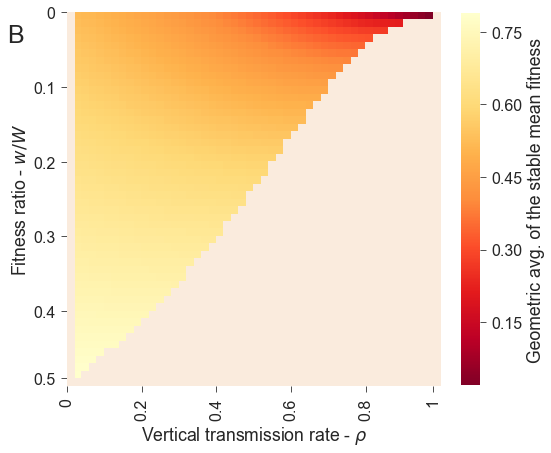

In [378]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(w_pivoted, square=True, ax=ax, cmap='YlOrRd_r', rasterized=True,
            cbar_kws=dict(fraction=0.045, 
                label='Geometric avg. of the stable mean fitness')#\n'+r'$(\bar{w}^* \cdot \bar{w}^{**} \cdot \bar{w}^{***})^{1/3}$')
           )
sns.heatmap(~np.isfinite(w_pivoted), mask=np.isfinite(w_pivoted), square=True, ax=ax, cbar=False)
ax.set_xticks([0, 10, 20, 30, 40, 49])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 10, 20, 30, 40, 49])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel(r'Vertical transmission rate - $\rho$')
ax.set_ylabel(r'Fitness ratio - $w/W$')
# ax.set_title(r'Polymorphism frequency in ABB - $x^*$')
fig_panel_labels(np.array(ax), 'B', xcoord=-0.16)

fig.tight_layout()
fig.savefig('../figures/A1B2_polymorphism_geom_wbar.pdf')#, **savefig_bbox(cb.))

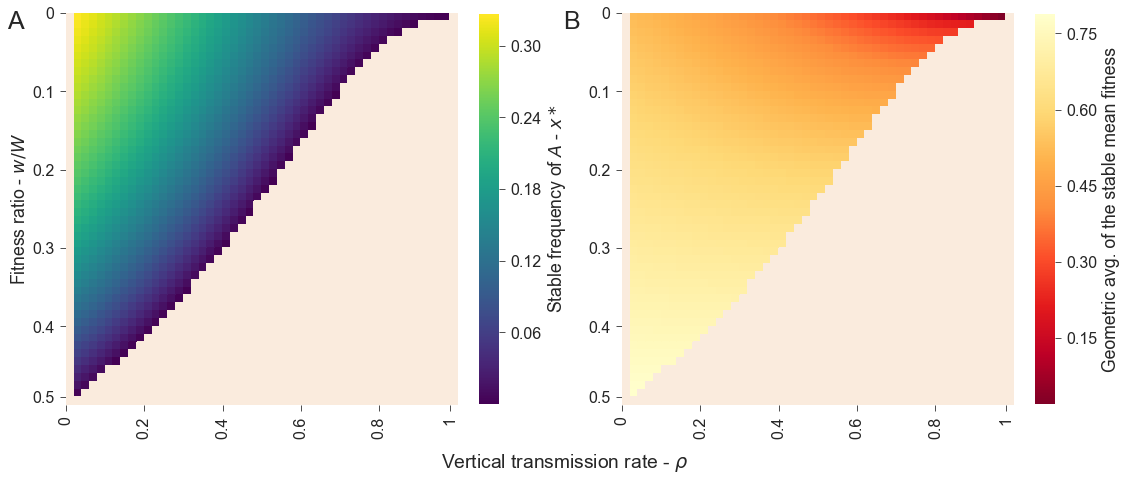

In [383]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

ax = axes[0]
sns.heatmap(x_pivoted, square=True, ax=ax, cmap='viridis', rasterized=True, 
            cbar_kws=dict(fraction=0.045, label='Stable frequency of $A$ - $x*$'))
sns.heatmap(~np.isfinite(x_pivoted), mask=np.isfinite(x_pivoted), square=True, ax=ax, rasterized=True, cbar=False)
# cntr = ax.contourf(pivoted)
# ax.clabel(cntr, colors='w')
ax.set_xticks([0, 10, 20, 30, 40, 49])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 10, 20, 30, 40, 49])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_xlabel('')
ax.set_ylabel(r'Fitness ratio - $w/W$')

ax = axes[1]
sns.heatmap(w_pivoted, square=True, ax=ax, cmap='YlOrRd_r', rasterized=True, 
            cbar_kws=dict(fraction=0.045, 
                label='Geometric avg. of the stable mean fitness')#\n'+r'$(\bar{w}^* \cdot \bar{w}^{**} \cdot \bar{w}^{***})^{1/3}$')
           )
sns.heatmap(~np.isfinite(w_pivoted), mask=np.isfinite(w_pivoted), square=True, ax=ax, rasterized=True, cbar=False)
ax.set_xticks([0, 10, 20, 30, 40, 49])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 10, 20, 30, 40, 49])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_ylabel('')
ax.set_xlabel('')
fig_panel_labels(axes , xcoord=-0.15, ycoord=0.96)

fig_xlabel(fig, r'Vertical transmission rate - $\rho$', ycoord=0.04)
fig.tight_layout()
fig.savefig('../figures/A1B2_polymorphism.pdf')#, **savefig_bbox(cb.))

Or merge with:
```sh
pdfjam figures/A1B2_polymorphism_x.pdf figures/A1B2_polymorphism_geom_wbar.pdf -o figures/A1B2_polymorphism.pdf --landscape --nup 2x1
```

# AkBl

In [323]:
@numba.jit()
def evolution(x0, wA, wB, ρ, err=1e-16):
    n = len(wA)
    assert n == len(wB)
    x = np.empty(n)
    x[0] = x0

    for t in range(n - 1):
        wA_, wB_ = wA[t], wB[t]
        wbar = x[t] * wA_ + (1 - x[t]) * wB_
        x[t + 1] = max(min(ρ * x[t] * wA_/wbar + (1-ρ) * x[t], 1-err), err)
    assert (x > 0).all()
    assert (x < 1).all()
    return x

In [324]:
import warnings

def geom_avg_wbar(x, wA, wB, k, l):
    warnings.filterwarnings("error")
    x = x[-k-l:]
    wA = wA[-k-l:]
    wB = wB[-k-l:]
    wbars = x * wA + (1 - x) * wB
    assert (wbars > 0).all(), wbars
    res = scipy.stats.mstats.gmean(wbars)
    assert 0 < res < 1, (res, k, l)
    return res

# # @numba.jit()
# def arit_avg_wbar(x, Ws, ws, k, l):
#     wbars = x[-k-l:] * (Ws - ws)[-k-l:] + ws[-k-l:]
#     res = np.mean(wbars)
#     assert 0 < res < 1, res
#     return res

In [325]:
def simulate(ρ, w, k, l, x0=0.5, n=1000):
    wA = np.array(([1]*k + [w]*l) * n, dtype=float)
    wB = np.array(([w]*k + [1]*l) * n, dtype=float)
    x = evolution(x0, wA, wB, ρ)
    gwbar = geom_avg_wbar(x, wA, wB, k, l)
#     awbar = arit_avg_wbar(x, Ws, ws, k, l)
    return gwbar

### Optimal $\rho$

In [385]:
ρs = np.linspace(0.0, 1.0, 100, dtype=float)
ks = np.arange(1, 51, 1, dtype=int)

w = 0.1
wbarAkBl01 = np.array([
    [
        simulate(ρ_, w, k_, k_)
        for ρ_ in ρs
    ]
    for k_ in ks
])

w = 0.5
wbarAkBl05 = np.array([
    [
        simulate(ρ_, w, k_, k_)
        for ρ_ in ρs
    ]
    for k_ in ks
])

w = 0.9
wbarAkBl09 = np.array([
    [
        simulate(ρ_, w, k_, k_)
        for ρ_ in ρs
    ]
    for k_ in ks
])

In [ ]:
fig, ax = plt.subplots()

ax.plot(ks, ρs[wbarAkBl01.argmax(axis=1)], '-o', label='0.1')
ax.plot(ks, ρs[wbarAkBl05.argmax(axis=1)], '-o', label='0.5')
ax.plot(ks, ρs[wbarAkBl09.argmax(axis=1)], '-o', label='0.9')
ax.set(
    xlabel='Environment period - $k=l$',
    ylabel=r'Optimal rate - $\hat{\rho}$',
    xticks=[1,10,20,30,40,50]
#     ylim=(0,1)
)
ax.legend(loc='lower right', title='$w$')
# fig_panel_labels(np.array(ax), 'B', ycoord=1.05)
fig.tight_layout()
sns.despine()

fig.savefig('../figures/AkBk_stable_wbar_slice.pdf')

### Everything

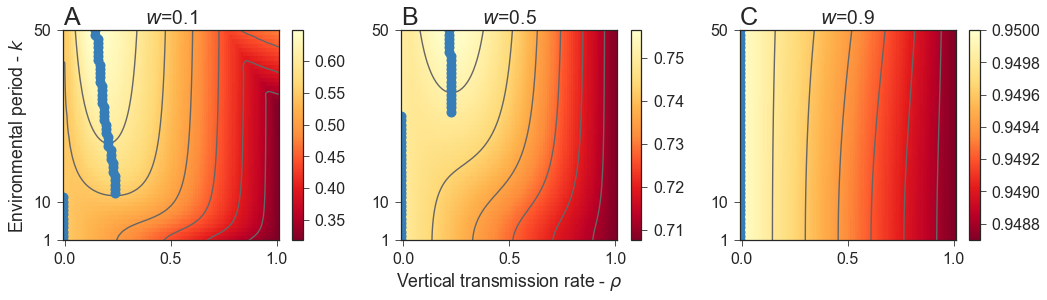

In [387]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

def _plot_(ax, wbarAkBl):
    im = ax.pcolormesh(ρs, ks, wbarAkBl, cmap='YlOrRd_r', rasterized=True)
    ax.contour(ρs, ks, wbarAkBl, colors='#666666')
    ax.plot(ρs[wbarAkBl.argmax(axis=1)], ks, 'o', markersize=10, color=blue)
    cb = plt.colorbar(im, ax=ax)
    ax.set_xticks([0.01, 0.5, 0.99])
    ax.set_xticklabels([0.0, 0.5, 1.0])
    ax.set_yticks([1, 10, 50])
    
_plot_(axes[0], wbarAkBl01)
_plot_(axes[1], wbarAkBl05)
_plot_(axes[2], wbarAkBl09)
axes[0].set_title('$w$=0.1')
axes[0].set_ylabel('Environmental period - $k$')
axes[1].set_xlabel(r'Vertical transmission rate - $\rho$')
axes[1].set_title('$w$=0.5')
axes[2].set_title('$w$=0.9')

fig_panel_labels(axes, xcoord=0, ycoord=1.025)
fig.tight_layout()

fig.savefig('../figures/AkBk_stable_wbar.pdf', **savefig_bbox(ylabel))

## Specifics

In [331]:
def wbar_opt_ρ(w, k, l):
    return ρs[np.array([
        simulate(ρ_, w, k, l)
        for ρ_ in ρs
    ]).argmax()]

In [334]:
rows = [
    dict(w=0.1, k=3, l=10),
    dict(w=0.1, k=5, l=30),
    dict(w=0.5, k=3, l=10),
    dict(w=0.5, k=5, l=30),
    dict(w=0.9, k=3, l=10),
    dict(w=0.9, k=5, l=30),
    dict(w=0.1, k=12, l=12),
    dict(w=0.5, k=30, l=30), 
]
for row in rows:
    row['ρ'] = wbar_opt_ρ(**row)
pd.DataFrame(rows)

,k,l,w,ρ
0,3,10,0.1,0.010101
1,5,30,0.1,0.010101
2,3,10,0.5,0.020202
3,5,30,0.5,0.010101
4,3,10,0.9,0.050505
5,5,30,0.9,0.020202
6,12,12,0.1,0.242424
7,30,30,0.5,0.000000


# AkBk - _m_ equilibrium dependence on intial conditions

In [232]:
@numba.jit()
def evolution(x0, wA, wB, ρ):
    n = len(wA)
    assert n == len(wB)
    x = np.empty((n, x0.size))
    x[0,:] = x0

    for t in range(n - 1):
        wA_, wB_ = wA[t], wB[t]
        wbar = x[t] * wA_ + (1 - x[t]) * wB_        
        x[t + 1] = ρ * x[t] * wA_/wbar + (1-ρ) * x[t]
        x[t + 1][x[t + 1] < 1e-14] = 1e-14
        x[t + 1][x[t + 1] > 1-1e-14] = 1-1e-14
    assert (x >= 0).all()
    assert (x <= 1).all()
    return x

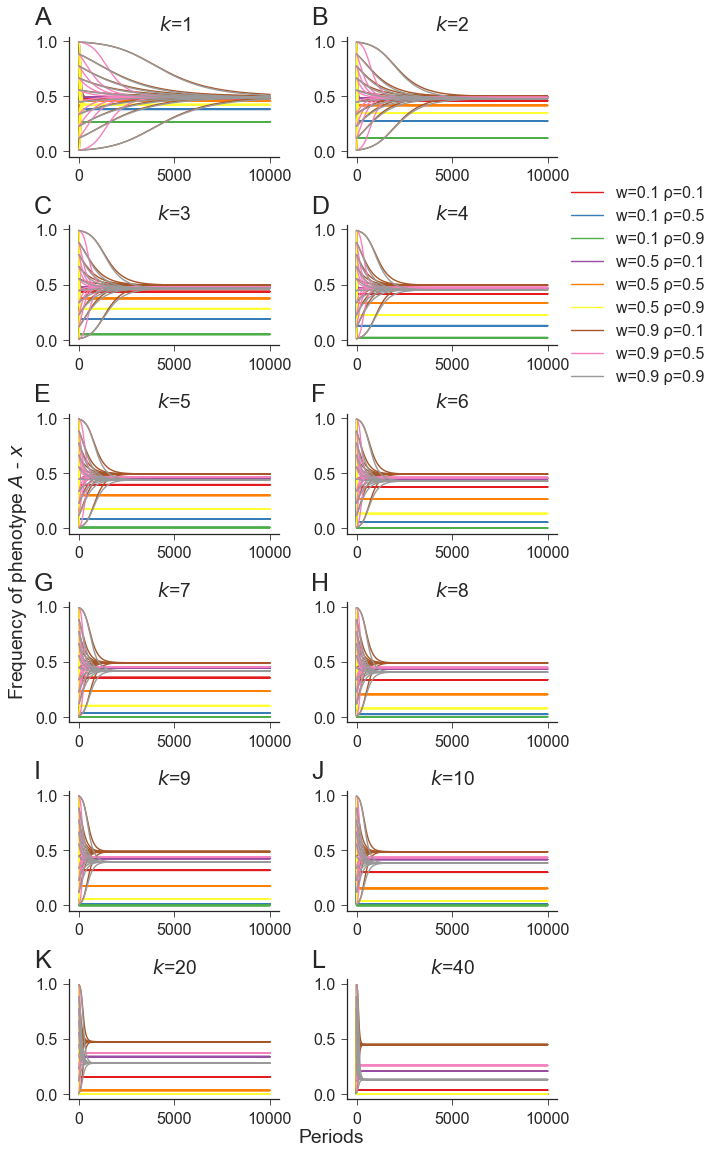

In [260]:
n = 10000
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.5, 0.9]
ws_ρs = [(w,ρ) for w in ws for ρ in ρs]
colors = sns.color_palette('Set1', 9)
x0s = np.linspace(0.01, 0.99, 10)
W_ = 1.0
ks = [1,2,3,4,5,6,7,8,9,10,20,40]

fig, axes = plt.subplots(6, 2, figsize=(8, 16), sharex=False, sharey="col")

for k, ax in zip(ks, axes.flat):
    lines = []
    for (w,ρ), color in zip(ws_ρs, colors): 
        wA = np.array(([1]*k + [w]*k) * n, dtype=float)
        wB = np.array(([w]*k + [1]*k) * n, dtype=float)
        x = evolution(x0s, wA, wB, ρ)
        line = ax.plot(x[::(2*k)], color=color)[0]
        lines.append(line)
        ax.set(
            xlabel='',
            ylabel='',
            title='$k$={}'.format(k)
        )

lg = legend_out(axes[1,1], 
    lines, ['w={:.1} ρ={:.1}'.format(*_) for _ in ws_ρs]
)
xlabel = fig_xlabel(fig, 'Periods', xcoord=0.55)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ - $x$', xcoord=0.025)
labels = fig_panel_labels(axes, ycoord=1.1)
fig.tight_layout()
sns.despine()
fig.savefig('../figures/AkBk_x0.pdf', 
            bbox_extra_artists=[xlabel, ylabel, lg] + labels, bbox_inches='tight');